In [1]:
from rlcard.utils.utils import remove_illegal
import numpy as np
import random
import collections
import enum
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import collections
import rlcard
import os
import datetime
import pickle
from rlcard.agents.nfsp_agent import ReservoirBuffer, DQNAgent
from rlcard.agents import RandomAgent
from rlcard.utils import get_device, set_seed, tournament, reorganize, Logger, plot_curve, remove_illegal


class AveragePolicyAgent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(self.env.state_shape[0][0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, self.env.num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=-1)


class AveragePolicyAgent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.env = env
        self.fc1 = nn.Linear(self.env.state_shape[0][0], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, self.env.num_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return F.log_softmax(x, dim=-1)


class NFSPAgent:
    def __init__(self, env, device):
        self.use_raw = False
        self._device = device
        
        self.eta = 0.1
        
        self.sample_size = 32
        
        self._rl_agent = DQNAgent(
            state_shape=env.state_shape[0],
            num_actions=env.num_actions,
            mlp_layers=[64, 64],
            device=device)
        self._m_sl = ReservoirBuffer(20000)
        self._avg_policy_agent = AveragePolicyAgent(env)
        self._avg_policy_agent.to(device)
        self._avg_policy_optimizer = torch.optim.Adam(self._avg_policy_agent.parameters(), lr=0.005)
        self.device = device
        self.model_path = './models'
        self.epochs = 0
        
    def eval_step(self, state):

        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        if np.random.rand() < self.eta:
            action, info = self._rl_agent.eval_step(state)
        else:
            action_probs = self._get_action_probs_from_policy(obs)
            action_probs = remove_illegal(action_probs, legal_actions)
            action = np.random.choice(len(action_probs), p=action_probs)
            info = {}
            info['probs'] = {state['raw_legal_actions'][i]: float(action_probs[list(state['legal_actions'].keys())[i]]) for i in range(len(state['legal_actions']))}
        
        return action, info
    
    def save(self, model_name):
        torch.save({
            'avg_policy': self._avg_policy_agent.state_dict(),
            'q_policy_estimator': self._rl_agent.q_estimator.qnet.state_dict(),
            'q_target_estimator': self._rl_agent.target_estimator.qnet.state_dict()
        }, self.model_path + '/' + model_name)

    def load(self, model_name):
        checkpoint = torch.load(self.model_path + '/' + model_name)
        self._avg_policy_agent.load_state_dict(checkpoint['avg_policy'])
        self._rl_agent.q_estimator.qnet.load_state_dict(checkpoint['q_policy_estimator'])
        self._rl_agent.target_estimator.qnet.load_state_dict(checkpoint['q_target_estimator'])
    
    def step(self, state):

        obs = state['obs']
        legal_actions = list(state['legal_actions'].keys())
        if np.random.rand() < self.eta:
            # make the rl agent act

            action = self._rl_agent.step(state)
            one_hot = np.zeros(env.num_actions)
            one_hot[action] = 1

            self._m_sl.add((obs, one_hot))
        else:
            # avg policy agent
            action_probs = self._get_action_probs_from_policy(obs)
            action_probs = remove_illegal(action_probs, legal_actions)
            action = np.random.choice(len(action_probs), p=action_probs)

        return action
    
    def train_avg_policy(self):
        if len(self._m_sl) < self.sample_size:
            return None
        
        sample = self._m_sl.sample(self.sample_size)
        
        self._avg_policy_agent.zero_grad()
        self._avg_policy_agent.eval()
        
        infostates = []
        action_probs = []
        for transition in sample:
            infostates.append(transition[0])
            action_probs.append(transition[1])
        
        infostates = torch.from_numpy(np.array(infostates)).float().to(self.device)
        eval_action_probs = torch.from_numpy(np.array(action_probs)).float().to(self.device)
        #eval_action_probs = eval_action_probs.long()
        log_action_probs = self._avg_policy_agent(infostates)
        #criterion = nn.MSELoss()
        #loss = criterion(log_action_probs, eval_action_probs)
        loss = -(eval_action_probs * log_action_probs).sum(dim=-1).mean()
        loss.backward()
        
        self._avg_policy_optimizer.step()
        self._avg_policy_agent.eval()
        loss_total = loss.item()
        return loss_total
    
    def _get_action_probs_from_policy(self, obs):
        obs = torch.from_numpy(obs).float().to(self.device)
        
        with torch.no_grad():
            action_probs = self._avg_policy_agent(obs)
        
        action_probs = action_probs.cpu().numpy()
        return np.exp(action_probs)


In [2]:
EPISODES = 200000
EVALUATE_EVERY = 1000
EVALUATION_GAMES = 2000
GAME = 'no-limit-holdem'

# Training

--> Running on the GPU

----------------------------------------
  timestep     |  7
  reward       |  -1.066
----------------------------------------
INFO - Step 100, rl-loss: 2513.863525390625
INFO - Copied model parameters to target network.
INFO - Step 1100, rl-loss: 2228.6054687531255
INFO - Copied model parameters to target network.
INFO - Step 1118, rl-loss: 2752.2138671875625
----------------------------------------
  timestep     |  7193
  reward       |  1.2645
----------------------------------------
INFO - Step 2100, rl-loss: 1269.3867187537525
INFO - Copied model parameters to target network.
INFO - Step 2233, rl-loss: 2791.3020019531255
----------------------------------------
  timestep     |  15572
  reward       |  3.6675
----------------------------------------
INFO - Step 3100, rl-loss: 2361.6469726562555
INFO - Copied model parameters to target network.
INFO - Step 3359, rl-loss: 2389.2927246093755
----------------------------------------
  timestep     |  24148
  r

INFO - Step 33749, rl-loss: 2812.3156738281255
----------------------------------------
  timestep     |  260781
  reward       |  5.6185
----------------------------------------
INFO - Step 34100, rl-loss: 1217.4187011718755
INFO - Copied model parameters to target network.
INFO - Step 35088, rl-loss: 2537.4604492187555
----------------------------------------
  timestep     |  270981
  reward       |  6.364
----------------------------------------
INFO - Step 35100, rl-loss: 3261.8330078125525
INFO - Copied model parameters to target network.
INFO - Step 36100, rl-loss: 2525.5390625093755
INFO - Copied model parameters to target network.
INFO - Step 36375, rl-loss: 2936.1157226562555
----------------------------------------
  timestep     |  280963
  reward       |  7.833
----------------------------------------
INFO - Step 37100, rl-loss: 1911.0157470703125
INFO - Copied model parameters to target network.
INFO - Step 37669, rl-loss: 2383.1374511718755
------------------------------

INFO - Step 69100, rl-loss: 2713.7075195312555
INFO - Copied model parameters to target network.
INFO - Step 70100, rl-loss: 977.87951660156255
INFO - Copied model parameters to target network.
INFO - Step 70362, rl-loss: 2705.6093751875755
----------------------------------------
  timestep     |  537709
  reward       |  5.7715
----------------------------------------
INFO - Step 71100, rl-loss: 2376.9404296875555
INFO - Copied model parameters to target network.
INFO - Step 71705, rl-loss: 3169.7441406257555
----------------------------------------
  timestep     |  548051
  reward       |  6.477
----------------------------------------
INFO - Step 72100, rl-loss: 2091.2646484375875
INFO - Copied model parameters to target network.
INFO - Step 73000, rl-loss: 1128.0678710937555
----------------------------------------
  timestep     |  558214
  reward       |  6.929
----------------------------------------
INFO - Step 73100, rl-loss: 1775.0638427734375
INFO - Copied model parameters

INFO - Step 105602, rl-loss: 1266.0281982421875
----------------------------------------
  timestep     |  805473
  reward       |  7.6855
----------------------------------------
INFO - Step 106100, rl-loss: 1012.6778564453125
INFO - Copied model parameters to target network.
INFO - Step 106966, rl-loss: 2313.1977539062575
----------------------------------------
  timestep     |  815875
  reward       |  7.461
----------------------------------------
INFO - Step 107100, rl-loss: 1125.7736816406255
INFO - Copied model parameters to target network.
INFO - Step 108100, rl-loss: 2018.1051025390625
INFO - Copied model parameters to target network.
INFO - Step 108324, rl-loss: 2113.8964843753755
----------------------------------------
  timestep     |  826241
  reward       |  6.135
----------------------------------------
INFO - Step 109100, rl-loss: 2236.2263183593755
INFO - Copied model parameters to target network.
INFO - Step 109705, rl-loss: 3113.8154296875575
----------------------

INFO - Step 141162, rl-loss: 1431.1557617187555
----------------------------------------
  timestep     |  1073561
  reward       |  5.7485
----------------------------------------
INFO - Step 142100, rl-loss: 1692.2934570312525
INFO - Copied model parameters to target network.
INFO - Step 142478, rl-loss: 3111.6713867187525
----------------------------------------
  timestep     |  1083626
  reward       |  5.81
----------------------------------------
INFO - Step 143100, rl-loss: 3794.1542968758755
INFO - Copied model parameters to target network.
INFO - Step 143798, rl-loss: 3368.5009765625755
----------------------------------------
  timestep     |  1093699
  reward       |  4.8625
----------------------------------------
INFO - Step 144100, rl-loss: 3073.8916015625555
INFO - Copied model parameters to target network.
INFO - Step 145100, rl-loss: 2247.2509765625255
INFO - Copied model parameters to target network.
INFO - Step 145178, rl-loss: 1034.5048828125555
-------------------

INFO - Step 177100, rl-loss: 3336.7392578125525
INFO - Copied model parameters to target network.
INFO - Step 177406, rl-loss: 3145.6467285156255
----------------------------------------
  timestep     |  1349728
  reward       |  5.6645
----------------------------------------
INFO - Step 178100, rl-loss: 2471.9433593751255
INFO - Copied model parameters to target network.
INFO - Step 178767, rl-loss: 2622.3979492187555
----------------------------------------
  timestep     |  1360100
  reward       |  5.989
----------------------------------------
INFO - Step 179100, rl-loss: 1075.3400878906255
INFO - Copied model parameters to target network.
INFO - Step 180100, rl-loss: 1280.6613769531255
INFO - Copied model parameters to target network.
INFO - Step 180144, rl-loss: 2325.6184082031255
----------------------------------------
  timestep     |  1370506
  reward       |  5.227
----------------------------------------
INFO - Step 181100, rl-loss: 1616.1096191406255
INFO - Copied model

INFO - Step 213100, rl-loss: 2455.6503906255625
INFO - Copied model parameters to target network.
INFO - Step 213362, rl-loss: 1259.4436035156255
----------------------------------------
  timestep     |  1620786
  reward       |  6.516
----------------------------------------
INFO - Step 214100, rl-loss: 2763.4814453125255
INFO - Copied model parameters to target network.
INFO - Step 214786, rl-loss: 2407.9204101562555
----------------------------------------
  timestep     |  1631273
  reward       |  6.3435
----------------------------------------
INFO - Step 215100, rl-loss: 1983.6604003906255
INFO - Copied model parameters to target network.
INFO - Step 216100, rl-loss: 2097.3706054687525
INFO - Copied model parameters to target network.
INFO - Step 216143, rl-loss: 1680.7199707031255
----------------------------------------
  timestep     |  1641523
  reward       |  6.5565
----------------------------------------
INFO - Step 217100, rl-loss: 2376.5305175781255
INFO - Copied mode

INFO - Step 249100, rl-loss: 1228.8482666015625
INFO - Copied model parameters to target network.
INFO - Step 249596, rl-loss: 1868.5573730468755
----------------------------------------
  timestep     |  1892728
  reward       |  5.48
----------------------------------------
INFO - Step 250100, rl-loss: 1804.6186523437555
INFO - Copied model parameters to target network.
INFO - Step 251013, rl-loss: 2478.6506347656255
----------------------------------------
  timestep     |  1903052
  reward       |  9.086
----------------------------------------
INFO - Step 251100, rl-loss: 2460.7797851562555
INFO - Copied model parameters to target network.
INFO - Step 252100, rl-loss: 1608.5371093751255
INFO - Copied model parameters to target network.
INFO - Step 252367, rl-loss: 2108.3461914062575
----------------------------------------
  timestep     |  1913539
  reward       |  4.1835
----------------------------------------
INFO - Step 253100, rl-loss: 2030.2076416015625
INFO - Copied model 

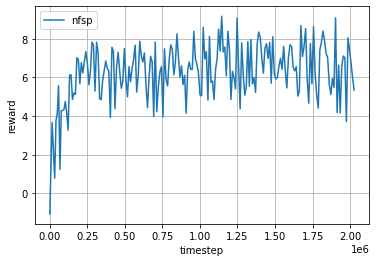

In [5]:
device = get_device()
# from rlcard.agents import NFSPAgent

env = rlcard.make(GAME, config={'seed': 0, 'game_num_players': 2})

nfsp = NFSPAgent(env, device)
nfsp.eta = 0.9

env.set_agents([nfsp, RandomAgent(num_actions=env.num_actions)])

# one episode
sl_loss = []
with Logger(f'./{GAME}-nfsp') as logger:
    for i in range(EPISODES):
        trajectories, payoffs = env.run(is_training=True) # requires a step method. Will populate the transition buffer m_sl
        trajectories = reorganize(trajectories, payoffs)

        for ts in trajectories[0]:
            #(state, action, reward, next_state, done) = tuple(ts)
            nfsp._rl_agent.feed(ts) # train the rl agent, populate the _m_rl buffer
            loss = nfsp.train_avg_policy()
            #nfsp.feed(ts)
        
#         nfsp.epochs += 1
        if i % EVALUATE_EVERY == 0:
            sl_loss.append(loss)
            logger.log_performance(env.timestep, tournament(env, EVALUATION_GAMES)[0])
        
        if i % 100000 == 0:
            nfsp.save('nfsp')
            
        
            
    csv_path, fig_path = logger.csv_path, logger.fig_path
    
plot_curve(csv_path, fig_path, 'nfsp')

In [6]:
nfsp.save('nfsp')

In [10]:
env = rlcard.make(GAME, config={'game_num_players': 2})
from rlcard.agents import RandomAgent
random_agent = RandomAgent(num_actions=env.num_actions)

def evaluate_games(a1, a2, env):
    env.set_agents([a1, a2])
    a1_wins = 0
    a2_wins = 0
    ties = 0
    episode_count = 0
    while episode_count != EVALUATION_GAMES:
        trajectories, payoffs = env.run(is_training=False)
        # If the human does not take the final action, we need to
        # print other players action
        final_state = trajectories[0][-1]
        action_record = final_state['action_record']
        state = final_state['raw_obs']
        _action_list = []
        for i in range(1, len(action_record)+1):
            if action_record[-i][0] == state['current_player']:
                break
            _action_list.insert(0, action_record[-i])

        if payoffs[0] > 0:
            a1_wins += 1
        elif payoffs[0] == 0:
            ties += 1
        else:
            a2_wins += 1

        episode_count += 1
    
    return a1_wins, a2_wins, ties


print(f"random wins, nfsp wins, ties = {evaluate_games(random_agent, nfsp, env)}")

random wins, nfsp wins, ties = (675, 1306, 19)


In [13]:
from rlcard.agents import RandomAgent
env = rlcard.make(GAME)

random_agent = RandomAgent(num_actions=env.num_actions)
print(f"random wins, nfsp wins, ties = {evaluate_games(random_agent, nfsp, env)}")

random wins, nfsp wins, ties = (98, 1895, 7)


In [19]:
from rlcard.agents import NolimitholdemHumanAgent as HumanAgent
from rlcard.utils.utils import print_card

env = rlcard.make(GAME, config={'game_num_players': 2})
human_agent = HumanAgent(env.num_actions)
env.set_agents([human_agent, nfsp])

print(">> No Limit Hold'em")

num_games = 10
total_games = 0
human_wins = 0
nfsp_wins = 0
ties = 0


while (num_games != total_games):
    print(">> Start a new game")

    trajectories, payoffs = env.run(is_training=False)
    # If the human does not take the final action, we need to
    # print other players action
    final_state = trajectories[0][-1]
    action_record = final_state['action_record']
    state = final_state['raw_obs']
    _action_list = []
    for i in range(1, len(action_record)+1):
        if action_record[-i][0] == state['current_player']:
            break
        _action_list.insert(0, action_record[-i])
    for pair in _action_list:
        print('>> Player', pair[0], 'chooses', pair[1])

    # Let's take a look at what the agent card is
    print('===============     Cards all Players    ===============')
    for hands in env.get_perfect_information()['hand_cards']:
        print_card(hands)

    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('You win {} chips!'.format(payoffs[0]))
        human_wins += 1
    elif payoffs[0] == 0:
        print('It is a tie.')
        ties += 1
    else:
        print('You lose {} chips!'.format(-payoffs[0]))
        nfsp_wins += 1
    print('')
    
    total_games += 1
    print(f'game_num = {total_games}')
    input("Press any key to continue...")

>> No Limit Hold'em
>> Start a new game

=============== Community Card ===============









=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│A        │   │2        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♦    │
│         │   │         │
│         │   │         │
│        A│   │        2│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 3
Remaining: [99, 98]

=========== Actions You Can Choose ===========
0: Action.FOLD, 1: Action.CALL, 2: Action.RAISE_POT, 3: Action.ALL_IN

{'hand': ['HA', 'D2'], 'public_cards': [], 'all_chips': [1, 2], 'my_chips': 1, 'legal_actions': [<Action.FOLD: 0>, <Action.CALL: 2>, <Action.RAISE_POT: 4>, <Action.ALL_IN: 5>], 'stakes': [99, 98], 'current_player': 0, 'pot': 3, 'stage': <Stage.PREFLOP: 0>}
>> You choose action (integer): 2
>> Player 1 chooses Action.RAISE_POT

=============== Community Card ===============









=============  Player 0 - Hand   ========

>> You choose action (integer): 1
>> Player 1 chooses Action.RAISE_POT

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐
│3        │   │5        │   │7        │
│         │   │         │   │         │
│         │   │         │   │         │
│    ♠    │   │    ♣    │   │    ♣    │
│         │   │         │   │         │
│         │   │         │   │         │
│        3│   │        5│   │        7│
└─────────┘   └─────────┘   └─────────┘
=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│A        │   │6        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♥    │
│         │   │         │
│         │   │         │
│        A│   │        6│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 16
Remaining: [96, 88]

=========== Actions You Can Choose ===========
0: Action.FOLD, 1: Action.CALL, 2: Action.RAISE_HALF_POT, 3: Action.RAISE_POT, 4: Action.ALL_IN

{'hand': ['HA', '

>> You choose action (integer): 2
>> Player 1 chooses Action.RAISE_POT

=============== Community Card ===============









=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│J        │   │3        │
│         │   │         │
│         │   │         │
│    ♠    │   │    ♥    │
│         │   │         │
│         │   │         │
│        J│   │        3│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 12
Remaining: [96, 92]

=========== Actions You Can Choose ===========
0: Action.FOLD, 1: Action.CALL, 2: Action.RAISE_HALF_POT, 3: Action.RAISE_POT, 4: Action.ALL_IN

{'hand': ['SJ', 'H3'], 'public_cards': [], 'all_chips': [4, 8], 'my_chips': 4, 'legal_actions': [<Action.FOLD: 0>, <Action.CALL: 2>, <Action.RAISE_HALF_POT: 3>, <Action.RAISE_POT: 4>, <Action.ALL_IN: 5>], 'stakes': [96, 92], 'current_player': 0, 'pot': 12, 'stage': <Stage.PREFLOP: 0>}
>> You choose action (integer): 1

=============== Community Card ===============


Press any key to continue...
>> Start a new game

=============== Community Card ===============









=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│Q        │   │6        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♣    │
│         │   │         │
│         │   │         │
│        Q│   │        6│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 3
Remaining: [99, 98]

=========== Actions You Can Choose ===========
0: Action.FOLD, 1: Action.CALL, 2: Action.RAISE_POT, 3: Action.ALL_IN

{'hand': ['CQ', 'C6'], 'public_cards': [], 'all_chips': [1, 2], 'my_chips': 1, 'legal_actions': [<Action.FOLD: 0>, <Action.CALL: 2>, <Action.RAISE_POT: 4>, <Action.ALL_IN: 5>], 'stakes': [99, 98], 'current_player': 0, 'pot': 3, 'stage': <Stage.PREFLOP: 0>}
>> You choose action (integer): 1
>> Player 1 chooses Action.RAISE_POT

=============== Community Card ===============









=============  Player 0 - Hand  

>> You choose action (integer): 1
>> Player 1 chooses Action.CHECK
===============     Cards all Players    ===============
┌─────────┐   ┌─────────┐
│Q        │   │6        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♣    │
│         │   │         │
│         │   │         │
│        Q│   │        6│
└─────────┘   └─────────┘
┌─────────┐   ┌─────────┐
│5        │   │8        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♣    │
│         │   │         │
│         │   │         │
│        5│   │        8│
└─────────┘   └─────────┘
===============     Result     ===============
You lose 54 chips!

game_num = 4
Press any key to continue...
>> Start a new game

=============== Community Card ===============









=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│Q        │   │2        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♠    │
│         │   │         │
│         │   │    

>> You choose action (integer): 1
>> Player 1 chooses Action.CHECK

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│6        │   │3        │   │2        │   │8        │   │J        │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│    ♣    │   │    ♠    │   │    ♦    │   │    ♣    │   │    ♠    │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│        6│   │        3│   │        2│   │        8│   │        J│
└─────────┘   └─────────┘   └─────────┘   └─────────┘   └─────────┘
=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│Q        │   │2        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♠    │
│         │   │         │
│         │   │         │
│        Q│   │        2│
└─────────┘   └───

>> You choose action (integer): 1

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│Q        │   │7        │   │4        │   │6        │   │7        │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│    ♦    │   │    ♦    │   │    ♠    │   │    ♥    │   │    ♣    │
│         │   │         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │   │         │
│        Q│   │        7│   │        4│   │        6│   │        7│
└─────────┘   └─────────┘   └─────────┘   └─────────┘   └─────────┘
=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│3        │   │J        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♦    │
│         │   │         │
│         │   │         │
│        3│   │        J│
└─────────┘   └─────────┘
===============     Chips

>> You choose action (integer): 1
>> Player 1 chooses Action.RAISE_POT

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐   ┌─────────┐
│3        │   │K        │   │3        │   │5        │
│         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │
│    ♦    │   │    ♠    │   │    ♣    │   │    ♣    │
│         │   │         │   │         │   │         │
│         │   │         │   │         │   │         │
│        3│   │        K│   │        3│   │        5│
└─────────┘   └─────────┘   └─────────┘   └─────────┘
=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│6        │   │A        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♣    │
│         │   │         │
│         │   │         │
│        6│   │        A│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 24
Remaining: [94, 82]

=========== Actions You Can Choose 

>> You choose action (integer): 3
>> Player 1 chooses Action.RAISE_HALF_POT

=============== Community Card ===============
┌─────────┐   ┌─────────┐   ┌─────────┐
│J        │   │J        │   │10       │
│         │   │         │   │         │
│         │   │         │   │         │
│    ♦    │   │    ♥    │   │    ♠    │
│         │   │         │   │         │
│         │   │         │   │         │
│        J│   │        J│   │       01│
└─────────┘   └─────────┘   └─────────┘
=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│10       │   │4        │
│         │   │         │
│         │   │         │
│    ♣    │   │    ♠    │
│         │   │         │
│         │   │         │
│       01│   │        4│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 108
Remaining: [52, 40]

=========== Actions You Can Choose ===========
0: Action.FOLD, 1: Action.CALL

{'hand': ['CT', 'S4'], 'public_cards': ['DJ', 'HJ', 'ST'], 'all_chips': [48,

Press any key to continue...
>> Start a new game

=============== Community Card ===============









=============  Player 0 - Hand   =============
┌─────────┐   ┌─────────┐
│J        │   │7        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♦    │
│         │   │         │
│         │   │         │
│        J│   │        7│
└─────────┘   └─────────┘
===============     Chips      ===============
In Pot: 3
Remaining: [99, 98]

=========== Actions You Can Choose ===========
0: Action.FOLD, 1: Action.CALL, 2: Action.RAISE_POT, 3: Action.ALL_IN

{'hand': ['HJ', 'D7'], 'public_cards': [], 'all_chips': [1, 2], 'my_chips': 1, 'legal_actions': [<Action.FOLD: 0>, <Action.CALL: 2>, <Action.RAISE_POT: 4>, <Action.ALL_IN: 5>], 'stakes': [99, 98], 'current_player': 0, 'pot': 3, 'stage': <Stage.PREFLOP: 0>}
>> You choose action (integer): 1
>> Player 1 chooses Action.RAISE_POT

=============== Community Card ===============









=============  Player 0 - Hand  

>> You choose action (integer): 1
>> Player 1 chooses Action.CHECK
===============     Cards all Players    ===============
┌─────────┐   ┌─────────┐
│J        │   │7        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♦    │
│         │   │         │
│         │   │         │
│        J│   │        7│
└─────────┘   └─────────┘
┌─────────┐   ┌─────────┐
│Q        │   │5        │
│         │   │         │
│         │   │         │
│    ♥    │   │    ♠    │
│         │   │         │
│         │   │         │
│        Q│   │        5│
└─────────┘   └─────────┘
===============     Result     ===============
You lose 54 chips!

game_num = 10
Press any key to continue...


In [20]:
print(f"human wins, agent wins, ties = {human_wins, nfsp_wins, ties}")

human wins, agent wins, ties = (3, 5, 2)
